In [1]:
from argparse import Namespace

import matplotlib.cm as cm
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader

import train_model
from Datasets import Array_Data_DataSet

plt.style.use('default')

In [2]:
config = Namespace(
    alpha=0.855530283836263,
    lr=0.000646193982679427,
    feature='CPSD_Phase_Feature',
    label_type='direction',
    curriculum=(-1, -1, -1, -1),
    step_size=10,
    gamma=0.5,
    batch_size=2,
)
val_path = train_model.dataset_path + '/10/val'
r_range = train_model.r_range

In [3]:
checkpoint = torch.load(f'models/{config.feature}_model.pt')
net = train_model.build_model(config)
net.load_state_dict(checkpoint)
net.eval()
net.cuda();

In [4]:
net

Resnet18_attConvLSTM(
  (feature): CPSD_Phase_Feature(
    (spectrogram): Spectrogram()
    (cropper): Crop()
    (cpsd_phase): CPSD_Phase_Spectrogram()
  )
  (pyramid): Pyramid(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(

## 在验证集上测试

In [38]:
ds_val = Array_Data_DataSet(val_path, True, config.label_type, r_range)
dl_val = DataLoader(ds_val, batch_size=1, shuffle=True, num_workers=16, drop_last=False)

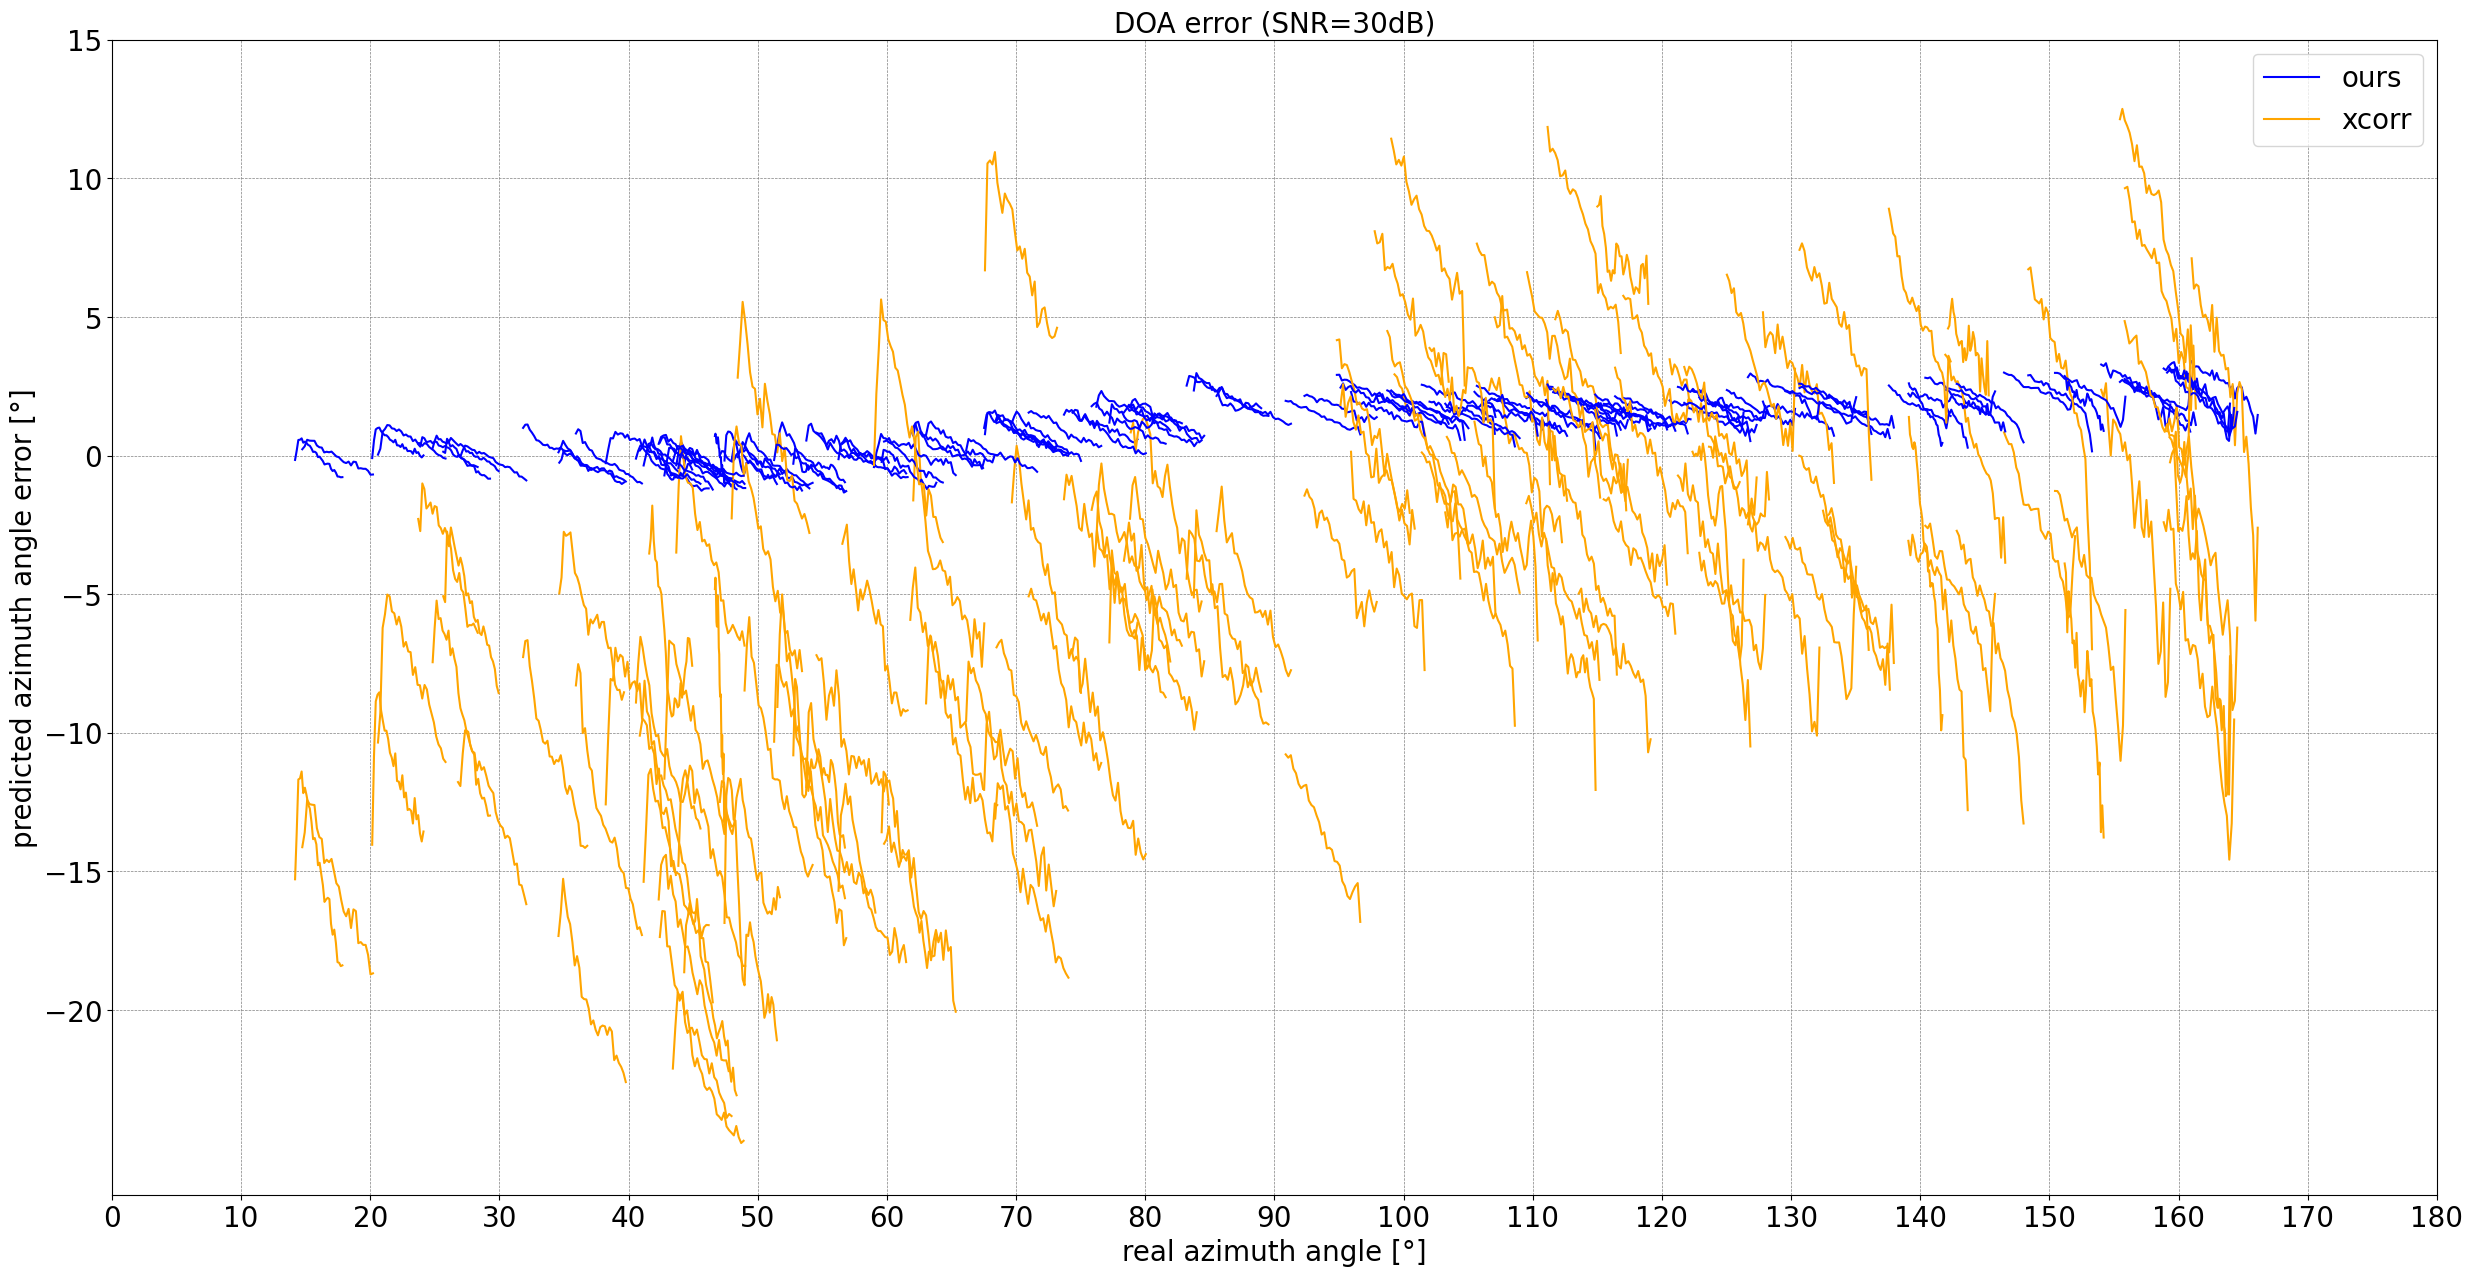

In [39]:
plt.figure(figsize=(30, 15))
plt.tick_params(axis='both', which='major', labelsize=20)
offset = np.arange(-3, 3, 0.2)
for i, (data, labels) in enumerate(dl_val):
    # if i == 3:
    #     break
    predicted = net(data.cuda())[0].detach().cpu()
    label_angles = ds_val.labels2angles(labels).numpy()
    if label_angles[0, 15] > 90:
        label_angles = label_angles + offset[::-1]
    else:
        label_angles = label_angles + offset
    predicted_angles = ds_val.labels2angles(predicted).numpy()
    label_angles = label_angles.squeeze()
    predicted_angles = predicted_angles.squeeze()
    plt.plot(label_angles, (predicted_angles - label_angles + 10)/5, color='blue', label='ours' if i == 0 else '')
    plt.plot(label_angles, (predicted_angles - label_angles) + np.random.randn() * 5, color='orange', label='xcorr' if i == 0 else '')
plt.legend(fontsize=20)  # 显示图例

plt.title('DOA error (SNR=30dB)', fontsize=20)
plt.xlabel('real azimuth angle [°]', fontsize=20)
plt.ylabel('predicted azimuth angle error [°]', fontsize=20)
plt.xticks(np.arange(0, 190, 10))
plt.yticks(np.arange(-20, 20, 5))
plt.grid(True, which='major', color='gray', linestyle='--', linewidth=0.5)

## 实时生成数据测试

In [20]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal

import feature_modules
from algorithm import *
from entity import Array_Data_Sampler, CW_Func_Handler, CW_Source, Three_Elements_Array
from utils import *

c = 1500
fc = 42500  # 声源频率
sample_interval = 1  # 采样时长
fs = 8 * fc  # 倍频采样频率
# fs = 500000  # 500k采样率

d = 0.5
K = 1

vel_angle = 90
speed = 0.5
r = 2000
angle = 60

velocity = deg_pol2cart(speed, vel_angle)

target_sig = CW_Func_Handler(
    f=fc,  # 声源频率
    prf=1,  # Cw信号周期
    pulse_width=10e-3,  # Cw信号脉宽
    device='cuda',
)
array_data_sampler = Array_Data_Sampler(
    CW_Source(
    signal_func_callback=target_sig,
    r=r,  # 声源距离
    angle=angle,  # 声源角度
    # seed=1,
    device='cuda',
),
    Three_Elements_Array(
        d=d,
        K=K,
        # seed=1000
        device='cuda',
    ),
    c=c,  # 声速
    device='cuda',
)

# array_data_sampler.set_ideal()
# array_data_sampler.set_SNR(30)
# array_data_sampler.set_SNR(20)
# array_data_sampler.set_SNR(10)
array_data_sampler.set_SNR(5)
# array_data_sampler.set_SNR(-5)
# array_data_sampler.set_SNR(-10)
# array_data_sampler.set_SNR(-15)
# array_data_sampler.set_SNR(-20)

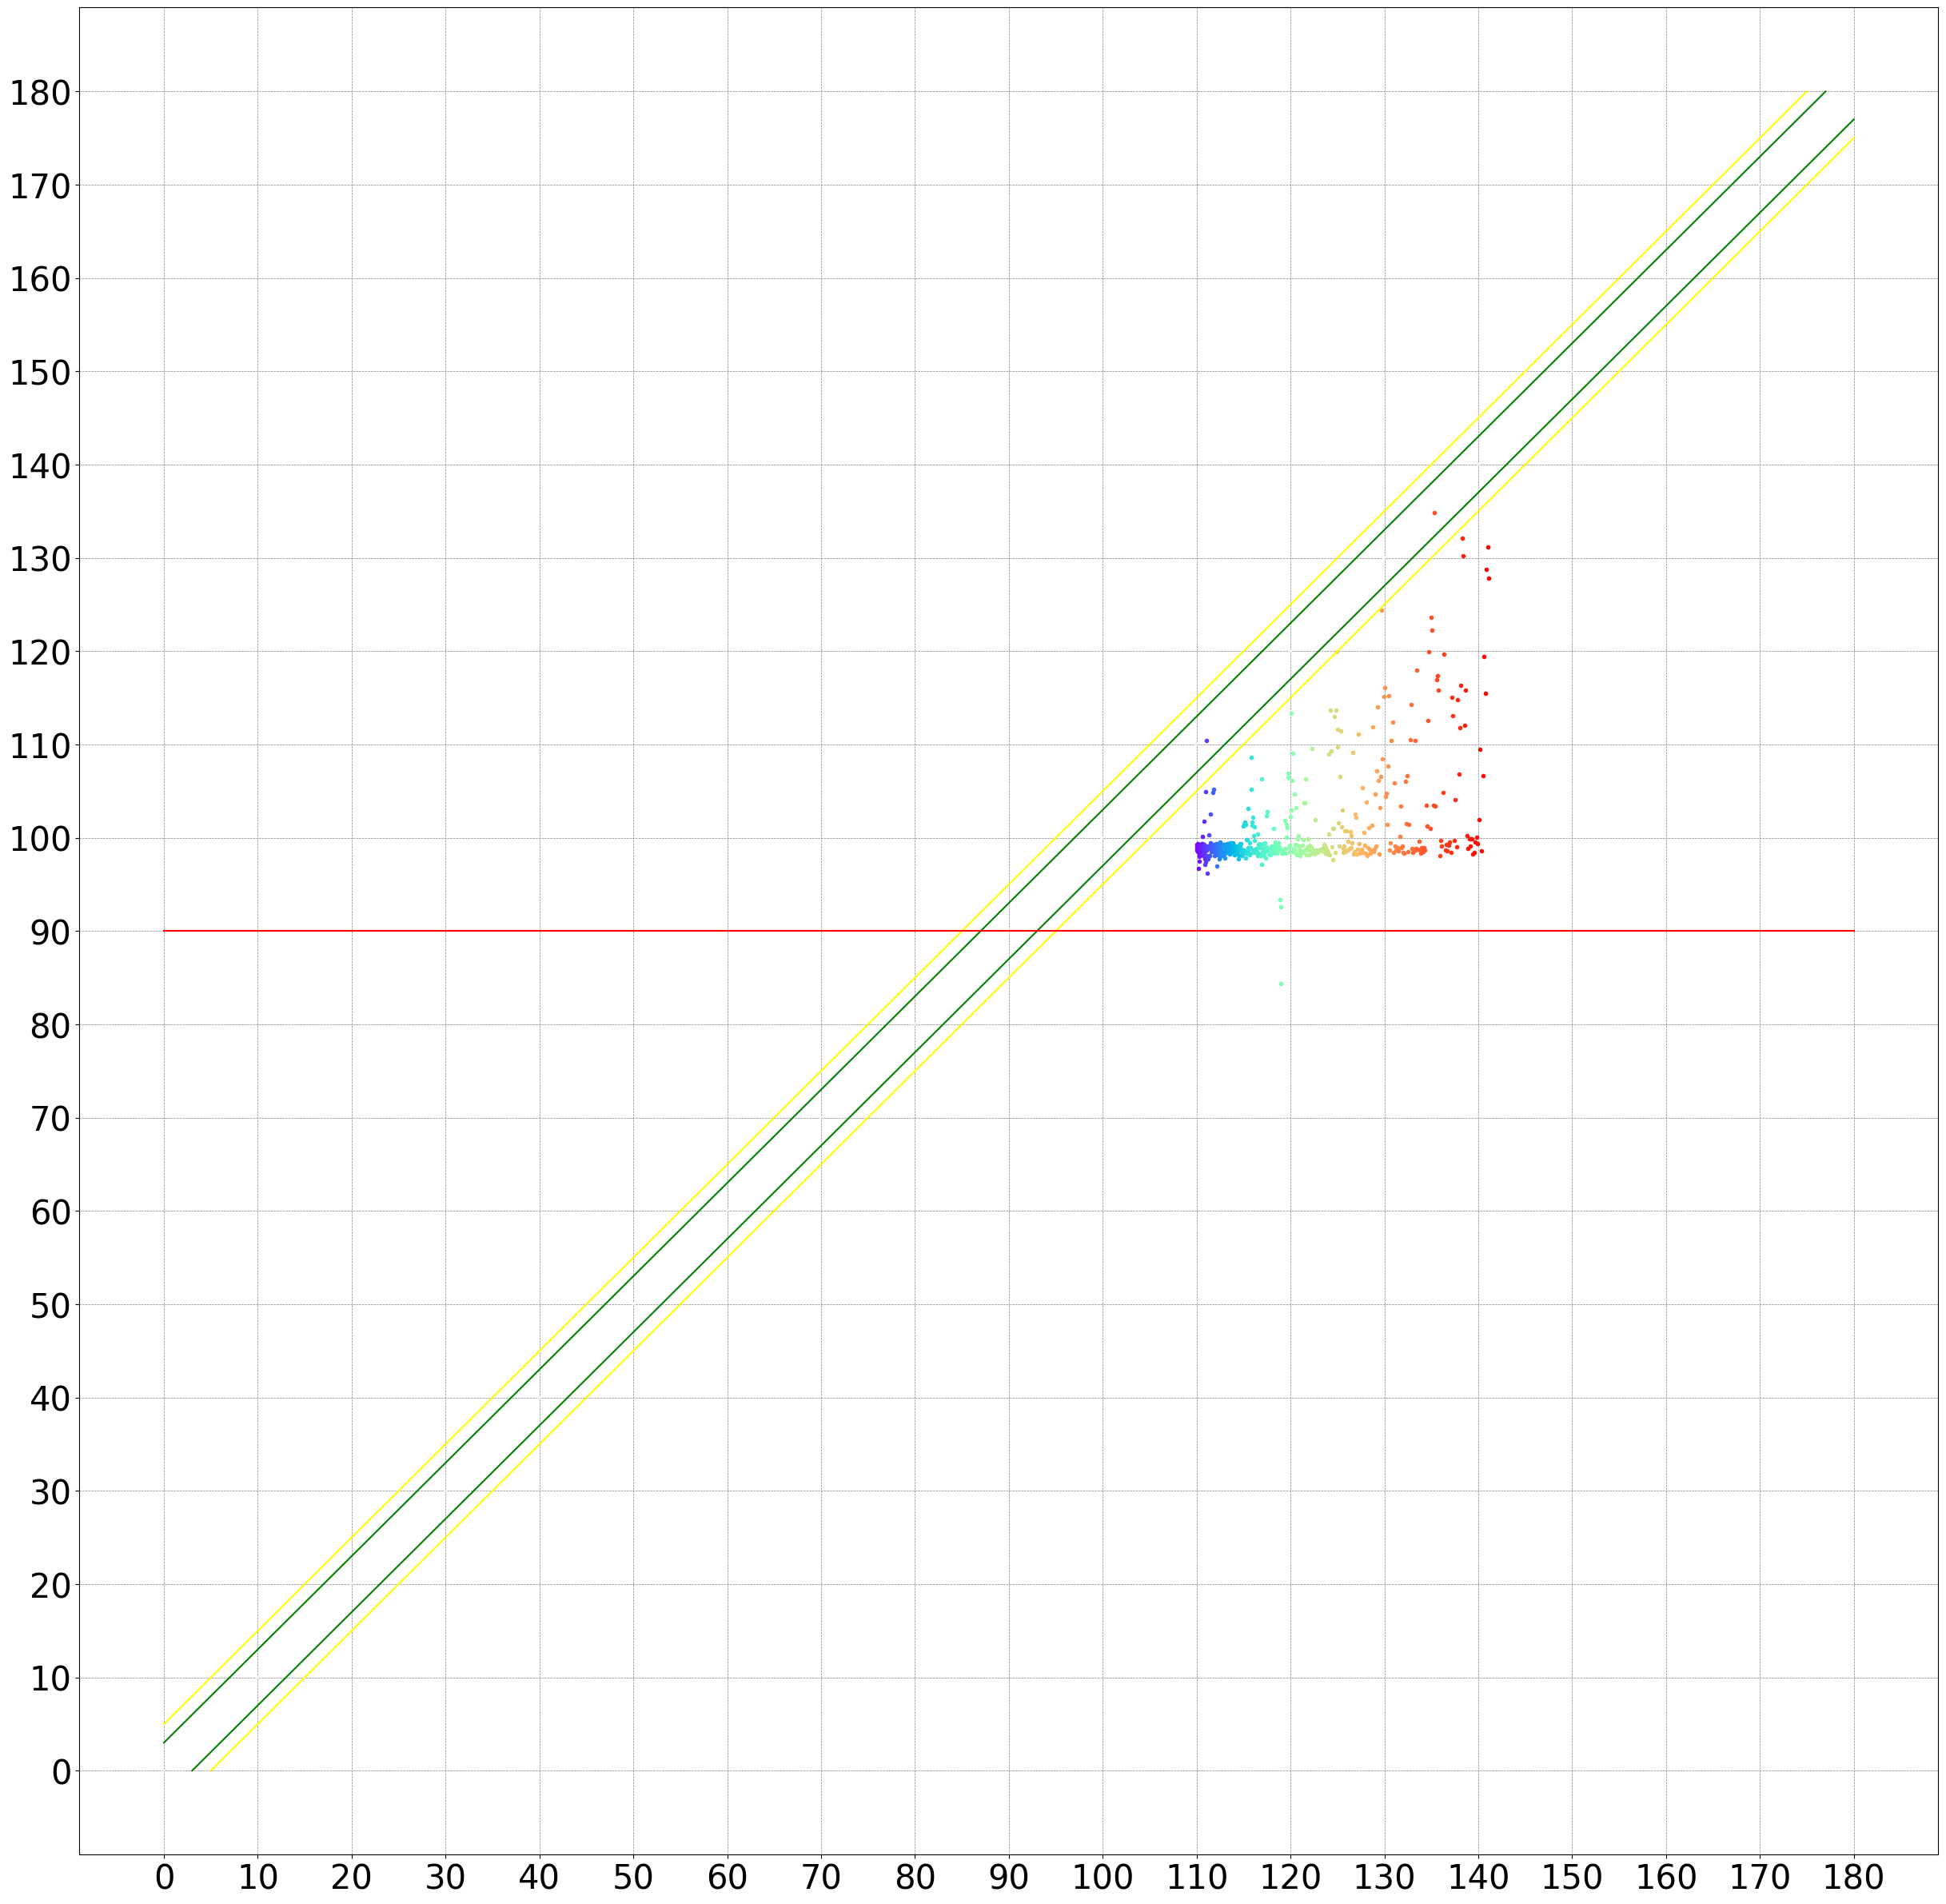

In [21]:
N = 200
colors = cm.rainbow(np.linspace(0, 1, N))  # type: ignore

plt.figure(figsize=(30, 30))
plt.tick_params(axis='both', which='major', labelsize=30)
t = np.arange(0, sample_interval, 1 / fs)
for i in range(N):
    x, r_real, angle_real, t_bound = array_data_sampler(t, velocity)
    t = t + 10
    data = torch.tensor(x, dtype=torch.float).unsqueeze(0).unsqueeze(0)
    predicted = net(data.cuda())[0].detach().cpu()
    predicted_angles = ds_val.labels2angles(predicted)
    plt.plot(angle_real, float(predicted_angles), '.', color=colors[i])
plt.plot([0, 180], [0, 180], 'white')
plt.plot([0, 177], [3, 180], 'green')
plt.plot([3, 180], [0, 177], 'green')
plt.plot([0, 175], [5, 180], 'yellow')
plt.plot([5, 180], [0, 175], 'yellow')
plt.plot([0, 180], [90, 90], 'red')
plt.xticks(np.arange(0, 190, 10))
plt.yticks(np.arange(0, 190, 10))
plt.grid(True, which='major', color='gray', linestyle='--', linewidth=0.5)
plt.show()

## 在真实数据上测试

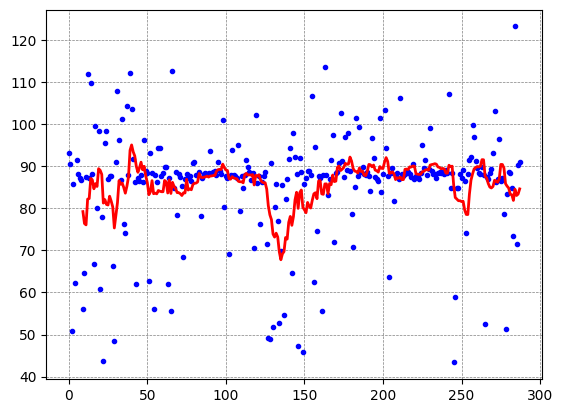

In [8]:
import os
import soundfile as sf
import torchaudio

fs = int(8 * 42.5e3)
ds_val = Array_Data_DataSet('.', True, config.label_type, r_range)
# plt.figure(figsize=(30, 30))
# plt.tick_params(axis='both', which='major', labelsize=30)
path = 'audio/9043_20240523134537约500m'
time = 0
N = 10
predicted_angles_list = []
moving_averages = []

for f in os.listdir(path):
    x, fs_high = sf.read(f'{path}/{f}')
    x = x.T[:-1, :]
    resampler = torchaudio.transforms.Resample(fs_high, fs)
    x_ds = resampler(torch.tensor(x).float())
    segments = torch.split(x_ds, fs, dim=1)
    segments = [segment for segment in segments if segment.shape[1] == fs]
    for i, seg in enumerate(segments):
        # if i % 5 != 0:
        #     continue
        data = seg.unsqueeze(0).unsqueeze(0)
        predicted = net(data.cuda())[0].detach().cpu()
        predicted_angles = ds_val.labels2angles(predicted)
        plt.plot(time, float(predicted_angles), 'b.')
        time += 1
        predicted_angles_list.append(float(predicted_angles))
        if len(predicted_angles_list) >= N:
            moving_avg = sum(predicted_angles_list[-N:]) / N
            moving_averages.append(moving_avg)

plt.plot(range(N - 1, len(moving_averages) + N - 1), moving_averages, 'r-', linewidth=2)
plt.grid(True, which='major', color='gray', linestyle='--', linewidth=0.5)
plt.show()